In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from scipy.optimize import minimize
import scipy.optimize as sco
from optim_funtions import *
import random
import warnings
warnings.filterwarnings('ignore')

2025-03-24 22:50:31.273221: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 22:50:31.286383: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 22:50:31.373452: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 22:50:31.474724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742831431.591264   55226 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742831431.61

In [2]:
df = pd.read_csv("../data/processed/transaction_history.csv")
df.head()

,stock_code,transaction_date,closing_price,matched_volume,matched_value,negotiated_volume,negotiated_value,opening_price,highest_price,lowest_price,change,percent
0,ABC,2016-08-18,39.7,25400.0,1.00,0.0,0.0,39.9,39.9,36.3,11.2,39.30
1,ABC,2016-08-19,37.5,23700.0,0.91,0.0,0.0,39.3,39.3,37.5,-1.7,-4.34
2,ABC,2016-08-22,36.0,13400.0,0.49,0.0,0.0,38.0,38.0,36.0,-2.3,-6.01
3,ABC,2016-08-23,34.8,5000.0,0.18,0.0,0.0,36.0,36.0,34.7,-1.8,-4.92
4,ABC,2016-08-24,35.0,16000.0,0.56,0.0,0.0,34.8,35.0,34.8,-0.3,-0.85


In [3]:
def read_data(file_path, list_stocks=None, start_time="2010-01-01", end_time="2025-01-01"):
    df = pd.read_csv(file_path)

    if not list_stocks:
        list_stocks = df['stock_code'].unique()

    result_df = {}

    for stock in list_stocks:
        data = df[df['stock_code'] == stock].copy()
        data['transaction_date'] = pd.to_datetime(data['transaction_date'])

        # Lag Features
        data['lag_1'] = data['closing_price'].shift(1)
        data['lag_5'] = data['closing_price'].shift(5)
        data['lag_10'] = data['closing_price'].shift(10)

        # Rolling Mean Features
        data['rolling_mean_5'] = data['closing_price'].rolling(window=5).mean()
        data['rolling_mean_10'] = data['closing_price'].rolling(window=10).mean()
        data['rolling_mean_20'] = data['closing_price'].rolling(window=20).mean()

        # Rolling Std Features
        data['rolling_std_5'] = data['closing_price'].rolling(window=5).std()
        data['rolling_std_10'] = data['closing_price'].rolling(window=10).std()
        data['rolling_std_20'] = data['closing_price'].rolling(window=20).std()

        # Expanding Mean Feature
        data['expanding_mean'] = data['closing_price'].expanding().mean()

        data = data.fillna(0)
        data = data.replace([np.inf, -np.inf], 0)
        data = data[(data["transaction_date"] >= start_time) & (data["transaction_date"] < end_time)]

        feature_columns = ['transaction_date', 'closing_price', 'lag_1', 'lag_5', 'lag_10', 
                           'rolling_mean_5', 'rolling_mean_10', 'rolling_mean_20', 
                           'rolling_std_5', 'rolling_std_10', 'rolling_std_20', 'expanding_mean']

        selected_data = data[feature_columns]
        result_df[stock] = selected_data

    return result_df


## Chuẩn bị data cho LSTM

In [4]:
def prepare_data(stock_data, sequence_length=10, target_column='closing_price', split_date="2024-01-01"):
    """
    Chuẩn bị dữ liệu cho mô hình LSTM
    
    Parameters:
    -----------
    stock_data : pandas DataFrame
        Dữ liệu cổ phiếu đã được xử lý
    sequence_length : int
        Độ dài chuỗi thời gian cho LSTM
    target_column : str
        Tên cột dữ liệu mục tiêu cần dự đoán
    split_date : str
        Ngày chia tách dữ liệu train/test
        
    Returns:
    --------
    Dictionary chứa dữ liệu đã xử lý cho LSTM
    """
    # Sắp xếp dữ liệu theo thời gian
    stock_data = stock_data.sort_values('transaction_date')
    df_train = stock_data[stock_data['transaction_date'] < split_date]
    df_test = stock_data[stock_data['transaction_date'] >= split_date]
    
    # Chọn các cột đặc trưng
    feature_columns = [col for col in stock_data.columns if col not in ['transaction_date', target_column]]
    
    X_train = df_train[feature_columns].values
    X_test = df_test[feature_columns].values
    y_train = df_train[target_column].values
    y_test = df_test[target_column].values
    
    # Chuẩn hóa dữ liệu
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
    
    # Tạo dữ liệu dạng chuỗi cho LSTM
    X_sequences, y_sequences = [], []
    for i in range(len(X_train_scaled) - sequence_length):
        X_sequences.append(X_train_scaled[i:i+sequence_length])
        y_sequences.append(y_train_scaled[i+sequence_length])
    
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)
    
    X_test_sequences, y_test_sequences = [], []
    for i in range(len(X_test_scaled) - sequence_length):
        X_test_sequences.append(X_test_scaled[i:i+sequence_length])
        y_test_sequences.append(y_test_scaled[i+sequence_length])
    
    if len(X_test_scaled) < sequence_length:
        combined_data = np.vstack((X_train_scaled[-sequence_length+len(X_test_scaled):], X_test_scaled))
        X_test_sequences = [combined_data[:sequence_length]]
        y_test_sequences = [y_test_scaled[0]]
    
    X_test_sequences = np.array(X_test_sequences)
    y_test_sequences = np.array(y_test_sequences)
    
    return {
    
        'X_train': X_sequences, 
        'y_train': y_sequences,
        'X_test': X_test_sequences, 
        'y_test': y_test_sequences,
        'scaler_y': scaler_y,
        'scaler_X': scaler_X,
        'sequence_length': sequence_length,
        'dates_test': stock_data['transaction_date'].values[-len(y_test):],
        'actual_test': y_test
    }

# Model LSTM

In [5]:
def build_lstm_model(prepared_data, units=50, dropout_rate=0.2, learning_rate=0.001, epochs=100, batch_size=32, patience=10):
    """
    Xây dựng và huấn luyện mô hình LSTM
    
    Parameters:
    -----------
    prepared_data : dict
        Dictionary chứa dữ liệu đã chuẩn bị cho LSTM
    units : int
        Số lượng units trong layer LSTM
    dropout_rate : float
        Tỷ lệ dropout để tránh overfitting
    learning_rate : float
        Tốc độ học của optimizer
    epochs : int
        Số lượng epochs huấn luyện
    batch_size : int
        Kích thước batch
    patience : int
        Số epochs đợi trước khi early stopping
        
    Returns:
    --------
    Mô hình LSTM đã huấn luyện và kết quả dự đoán
    """

    X_train = prepared_data['X_train']
    y_train = prepared_data['y_train']
    X_test = prepared_data['X_test']
    scaler_y = prepared_data['scaler_y']
    

    input_shape = (X_train.shape[1], X_train.shape[2])
    
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    
    return {
        'model': model,
        'history': history,
        'predictions': y_pred.flatten(),
        'predictions_scaled': y_pred_scaled.flatten()
    }

In [6]:
def compute_features(history_prices):
    
    series = pd.Series(history_prices)

    # Giá đóng cửa của ngày mới nhất
    cp = series.iloc[-1]

    # Lag Features
    lag_1 = series.shift(1).iloc[-1] if len(series) >= 2 else 0
    lag_5 = series.shift(5).iloc[-1] if len(series) >= 6 else 0
    lag_10 = series.shift(10).iloc[-1] if len(series) >= 11 else 0

    # Rolling Mean Features
    if len(series) >= 5:
        rolling_mean_5 = series.rolling(window=5).mean().iloc[-1]
    else:
        rolling_mean_5 = series.mean()
        
    if len(series) >= 10:
        rolling_mean_10 = series.rolling(window=10).mean().iloc[-1]
    else:
        rolling_mean_10 = series.mean()
        
    if len(series) >= 20:
        rolling_mean_20 = series.rolling(window=20).mean().iloc[-1]
    else:
        rolling_mean_20 = series.mean()

    # Rolling Std Features
    if len(series) >= 5:
        rolling_std_5 = series.rolling(window=5).std().iloc[-1]
    else:
        rolling_std_5 = series.std()
        
    if len(series) >= 10:
        rolling_std_10 = series.rolling(window=10).std().iloc[-1]
    else:
        rolling_std_10 = series.std()
        
    if len(series) >= 20:
        rolling_std_20 = series.rolling(window=20).std().iloc[-1]
    else:
        rolling_std_20 = series.std()

    # Expanding Mean Feature
    expanding_mean = series.expanding().mean().iloc[-1]

    return [lag_1, lag_5, lag_10,
            rolling_mean_5, rolling_mean_10, rolling_mean_20,
            rolling_std_5, rolling_std_10, rolling_std_20,
            expanding_mean]


In [7]:

def predict_future_days(lstm_model, prepared_data, current_data, days=21):
    """
    Dự đoán giá cổ phiếu cho nhiều ngày tiếp theo
    
    Parameters:
    -----------
    models_info : dict
        Dictionary chứa các mô hình đã huấn luyện
    current_data : array
        Dữ liệu hiện tại làm cơ sở cho dự đoán
    days : int
        Số ngày cần dự đoán
        
    Returns:
    --------
    Dictionary chứa kết quả dự đoán cho nhiều ngày
    """
    
    scaler_X = prepared_data['scaler_X']
    scaler_y = prepared_data['scaler_y']
    sequence_length = prepared_data['sequence_length']
    
    latest_data = current_data.copy()
    
    latest_scaled = latest_data[-sequence_length:]
    #  = scaler_X.transform(latest_features)
    
    # Dự đoán cho nhiều ngày tiếp theo
    future_predictions = []
    
    for day in range(days):
        # Dự đoán LSTM
        latest_sequence = latest_scaled.reshape(1, sequence_length, latest_scaled.shape[1])
        lstm_pred_scaled = lstm_model.predict(latest_sequence)
        lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled)[0][0]
        
        
        future_predictions.append(lstm_pred)
        
        #
        new_features = compute_features(np.append(latest_data[:, 0], lstm_pred))
        new_features_scaled = scaler_X.transform(np.array([new_features]))
    
        latest_scaled = np.vstack((latest_scaled[1:], new_features_scaled))
    
    return future_predictions

## Tối ưu hóa danh mục

In [54]:
file_path = "../data/processed/stock_data_final.csv"
list_stock = ['TMB', 'HGM', 'PVS', 'PVD', 'FPT', 'ITD', 'VIC', 'ACB', 'VCB','MBB']
all_data = read_data(file_path=file_path, list_stocks=list_stock)

sequence_length = 20

market_returns_data = pd.DataFrame()

all_predictions = {}
all_models = {}
all_stats = {}
all_predictions_1_months = {}

for stock_code in list_stock:
    
    stock_data = all_data[stock_code]
    market_returns_data[stock_code] = stock_data['closing_price'].pct_change()[(stock_data['transaction_date'] < "2024-01-01") & (stock_data['transaction_date'] >= "2023-01-01")].reset_index(drop=True)
    prepared_data = prepare_data(stock_data, sequence_length=sequence_length)
    
    lstm_results = build_lstm_model(
        prepared_data, 
        units=64, 
        dropout_rate=0.2, 
        learning_rate=0.001, 
        epochs=5, 
        batch_size=16
    )

    stock_data = all_data[stock_code]
    train_data = stock_data[stock_data['transaction_date'] < "2024-01-01"]
    test_data = stock_data[(stock_data['transaction_date'] >= "2024-01-01") & (stock_data['transaction_date'] < "2024-02-01")]

    history_prices = list(train_data["closing_price"].values)
    
    
    last_sequence_unscaled = train_data.iloc[-sequence_length:, :].drop(columns=['transaction_date', "closing_price"])
    print(last_sequence_unscaled.shape)
    scaler_x = prepared_data['scaler_X']
    last_sequence = scaler_x.transform(last_sequence_unscaled)

    n_days = test_data.shape[0]

    predictions = predict_future_days(lstm_results['model'], prepared_data, last_sequence, days=n_days)
    all_predictions[stock_code] = {'y_test': test_data['closing_price'], 'y_pred':predictions}

    risk_stats = calculate_returns_risk(predictions)

    all_stats[stock_code] = {
        'stats': risk_stats
    }



Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0144 - val_loss: 0.0668
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0043 - val_loss: 0.0203
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0031 - val_loss: 0.0171
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - val_loss: 0.0106
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
(20, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


In [51]:
for stock_code in list_stock:
    all_predictions[stock_code]['y_test'] = all_predictions[stock_code]['y_test'].values

In [52]:
expected_returns = []
risks = []
sharpe_ratios = []
market_caps = []

stocks_by_sharpe = sorted(
    all_stats.items(),
    key=lambda x: x[1]['stats']['sharpe_ratio'],
    reverse=True
)

top_n = min(len(stocks_by_sharpe), 5)  
selected_stocks = stocks_by_sharpe[:top_n]

selected_symbols = []
for symbol, stats in selected_stocks:
    selected_symbols.append(symbol)
    expected_returns.append(stats['stats']['expected_return'])
    risks.append(stats['stats']['risk'])
    sharpe_ratios.append(stats['stats']['sharpe_ratio'])


market_data = market_returns_data[selected_symbols].values
market_data = np.nan_to_num(market_data, nan=0.0, posinf=0.0, neginf=0.0)
cov_matrix = np.cov(market_data, rowvar=False)


In [53]:
# Định nghĩa các mốc thời gian (số phiên giao dịch)
time_horizons = {
    '1_month': 21,
}

scaler_y = prepared_data['scaler_y']
horizon_optimization_results = {}


for horizon, days in time_horizons.items():
    horizon_expected_returns = []
    horizon_risks = []
    horizon_sharpe_ratios = []

    for stock_code in selected_symbols:
        predictions = all_predictions[stock_code]['y_pred']

        if len(predictions) >= days:
            pred_horizon = predictions[0:(days + 1)]
        else:
            pred_horizon = predictions

        stats = calculate_returns_risk(pred_horizon)
        horizon_expected_returns.append(stats['expected_return'])
        horizon_risks.append(stats['risk'])
        horizon_sharpe_ratios.append(stats['sharpe_ratio'])

    # (Tùy chọn) Điều chỉnh "views" dựa trên Sharpe ratio, tương tự như đoạn code gốc
    # views = horizon_expected_returns.copy()
    # for i in range(len(views)):
    #     if horizon_sharpe_ratios[i] > 1.0:
    #         views[i] *= 1.1
    #     elif horizon_sharpe_ratios[i] < 0.5:
    #         views[i] *= 0.9

    # Tối ưu hóa với MVO
    mvo_weights = mvo_optimization(horizon_expected_returns, cov_matrix, max_weight=0.8)
    port_return = portfolio_return(mvo_weights, horizon_expected_returns)
    port_risk = portfolio_volatility(mvo_weights, cov_matrix)
    port_sharpe = (port_return - 0.02/252) / port_risk if port_risk > 0 else 0

    # ---------------------------
    # Tối ưu hóa với Monte Carlo (Max Sharpe)
    mc_results = monte_carlo_simulation(horizon_expected_returns, cov_matrix)
    mc_weights = mc_results['max_sharpe']['weights']
    mc_port_return = portfolio_return(mc_weights, horizon_expected_returns)
    mc_port_risk = portfolio_volatility(mc_weights, cov_matrix)
    mc_port_sharpe = (mc_port_return - 0.02/252) / mc_port_risk if mc_port_risk > 0 else 0

    # Lưu kết quả tối ưu hóa cho mốc thời gian hiện tại
    horizon_optimization_results[horizon] = {
        'mvo': {
            'weights': mvo_weights,
            'return': port_return,
            'risk': port_risk,
            'sharpe': port_sharpe
        },
        'monte_carlo': {
            'weights': mc_weights,
            'return': mc_port_return,
            'risk': mc_port_risk,
            'sharpe': mc_port_sharpe
        }
    }

    # Hiển thị kết quả cho mốc thời gian hiện tại
    print(f"\n=== Kết quả cho mốc thời gian: {horizon} ===")

    print("\n[MVO]")
    print(f"  Expected Return: {port_return:.6f}")
    print(f"  Risk: {port_risk:.6f}")
    print(f"  Sharpe Ratio: {port_sharpe:.6f}")
    print("  Weights:")
    for i, symbol in enumerate(selected_symbols):
        print(f"    {symbol}: {mvo_weights[i]:.4f} ({mvo_weights[i]*100:.2f}%)")

    print("\n[Monte Carlo - Max Sharpe]")
    print(f"  Expected Return: {mc_port_return:.6f}")
    print(f"  Risk: {mc_port_risk:.6f}")
    print(f"  Sharpe Ratio: {mc_port_sharpe:.6f}")
    print("  Weights:")
    for i, symbol in enumerate(selected_symbols):
        print(f"    {symbol}: {mc_weights[i]:.4f} ({mc_weights[i]*100:.2f}%)")


=== Kết quả cho mốc thời gian: 1_month ===

[MVO]
  Expected Return: 0.004987
  Risk: 0.016844
  Sharpe Ratio: 0.291387
  Weights:
    ITD: 0.8000 (80.00%)
    FPT: 0.0000 (0.00%)
    ACB: 0.0000 (0.00%)
    PVD: 0.2000 (20.00%)
    MBB: 0.0000 (0.00%)

[Monte Carlo - Max Sharpe]
  Expected Return: 0.005521
  Risk: 0.016820
  Sharpe Ratio: 0.323530
  Weights:
    ITD: 0.8323 (83.23%)
    FPT: 0.0005 (0.05%)
    ACB: 0.0580 (5.80%)
    PVD: 0.0898 (8.98%)
    MBB: 0.0195 (1.95%)


In [45]:
print(np.isnan(market_data).sum())  # Số lượng NaN
print((market_data == 0).sum())  # Số lượng số 0
print(market_data[:5])  # Xem vài dòng đầu


0
465
[[ 0.          0.          0.          0.          0.        ]
 [-0.00840336  0.05576208  0.          0.05263158  0.0325    ]
 [ 0.01694915 -0.01408451  0.          0.          0.00242131]
 [ 0.          0.00357143  0.          0.01111111  0.01449275]
 [-0.025      -0.00177936  0.          0.          0.        ]]


In [46]:
print(np.var(market_data, axis=0))  # Xem phương sai của từng cột

[0.00037594 0.000387   0.00021334 0.00021176 0.00018721]


In [47]:
print("Expected Returns:", expected_returns)
print("Covariance Matrix:\n", cov_matrix)

Expected Returns: [np.float32(0.04906456), np.float32(0.040448006), np.float32(0.02884608), np.float32(12.337057), np.float32(-0.03909769)]
Covariance Matrix:
 [[ 3.77391176e-04  4.43251381e-05 -3.83303089e-05  4.78389152e-05
   9.63571213e-06]
 [ 4.43251381e-05  3.88494449e-04 -2.48102870e-05  1.09643645e-04
   3.69392725e-05]
 [-3.83303089e-05 -2.48102870e-05  2.14162309e-04 -1.06389011e-05
   1.43609378e-06]
 [ 4.78389152e-05  1.09643645e-04 -1.06389011e-05  2.12576037e-04
   5.43045378e-05]
 [ 9.63571213e-06  3.69392725e-05  1.43609378e-06  5.43045378e-05
   1.87933224e-04]]


In [48]:
from plot_results import *

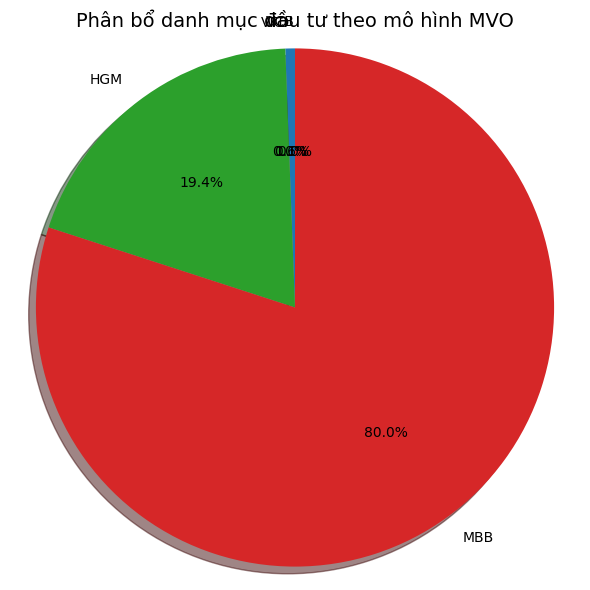

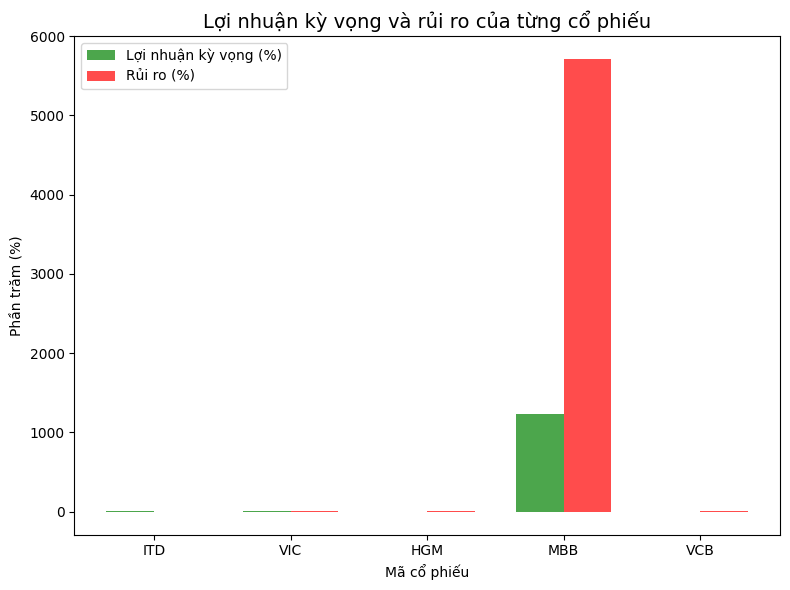

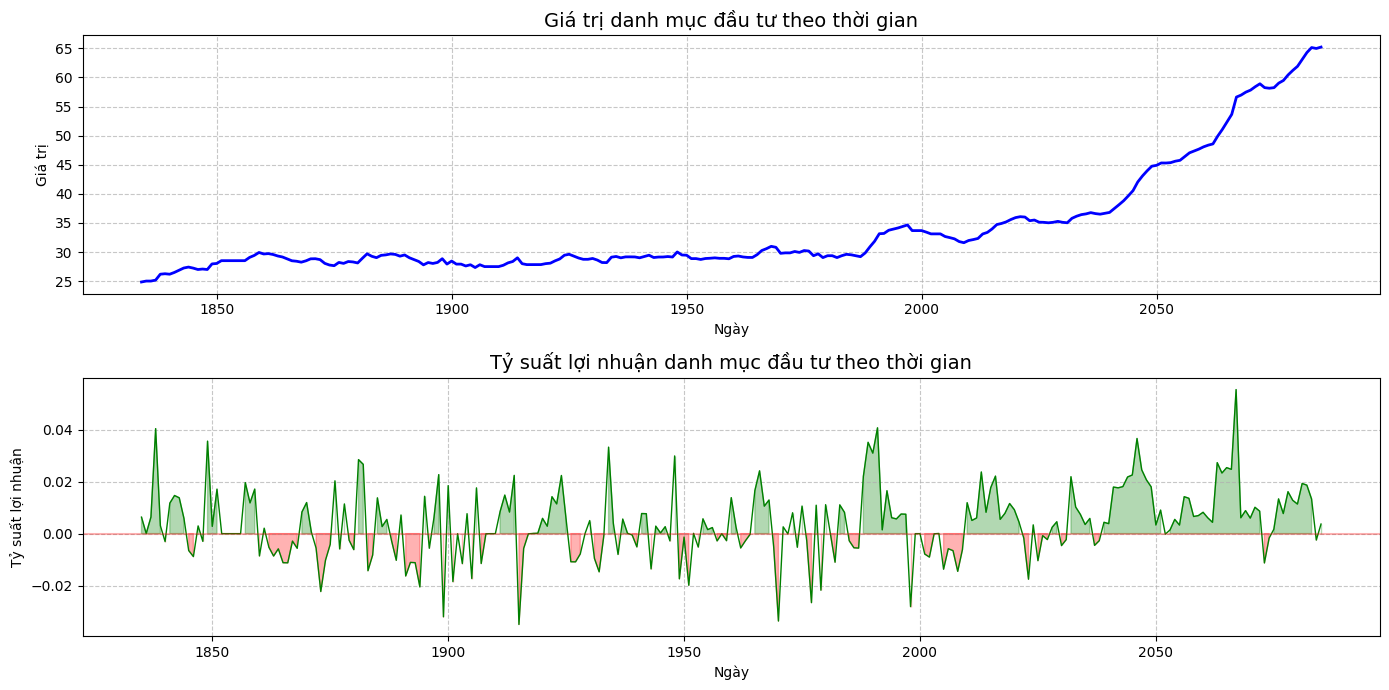

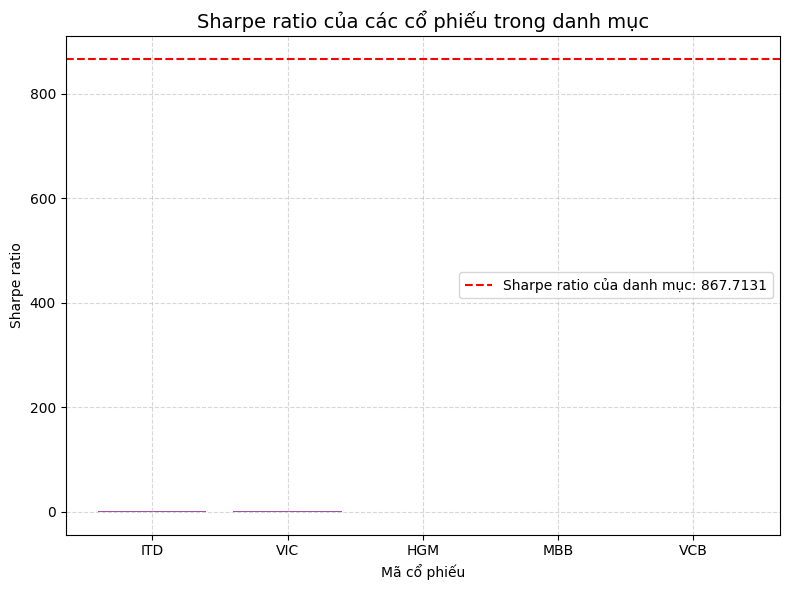

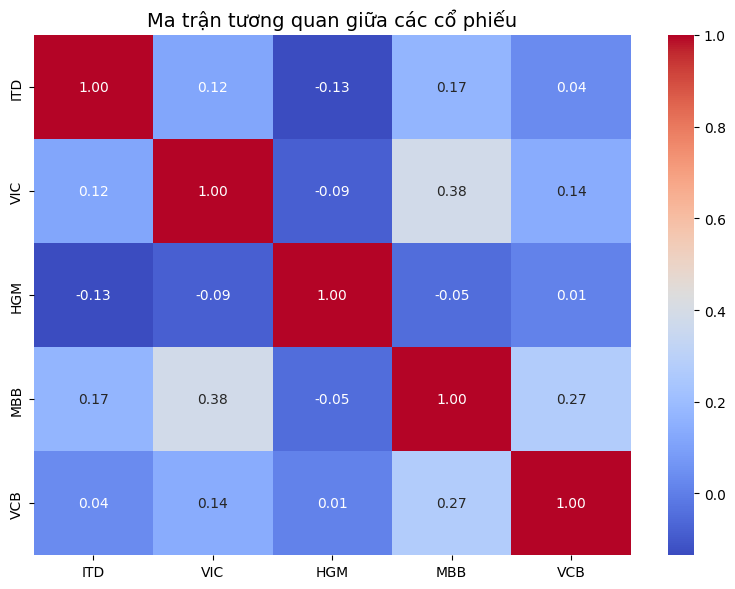

ValueError: num must be an integer with 1 <= num <= 4, not 5

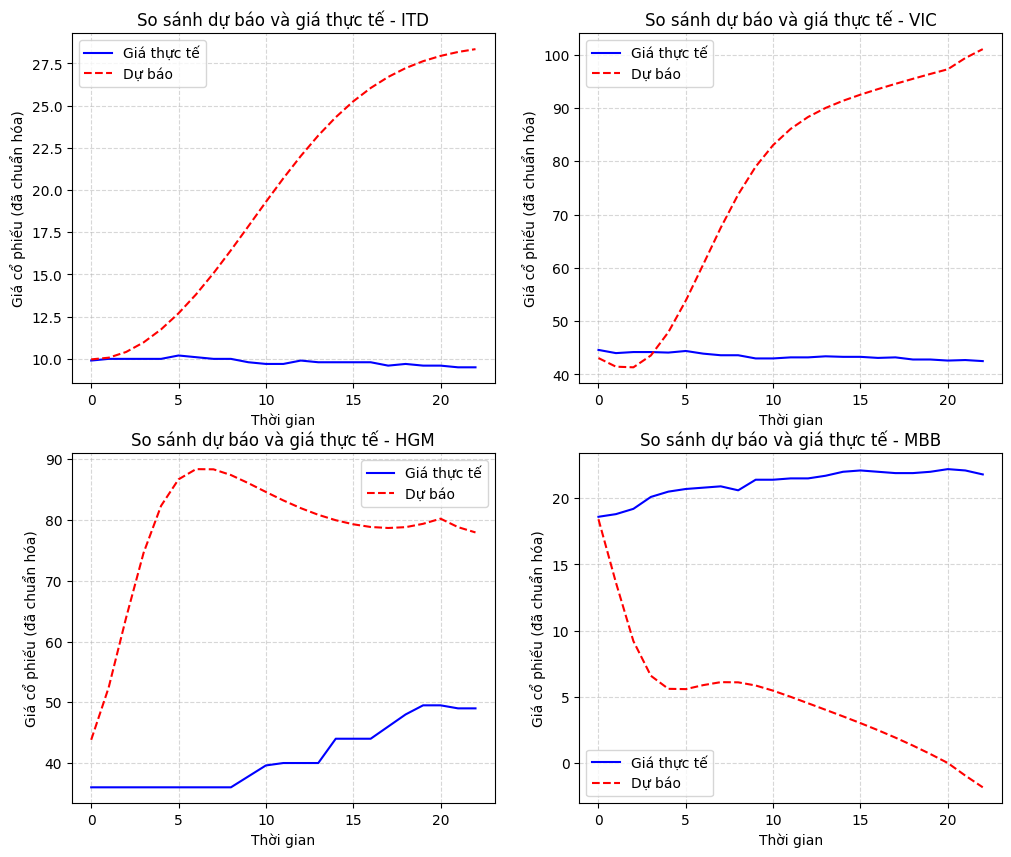

In [49]:
plot_portfolio_allocation(mvo_weights, selected_symbols)
plot_return_risk_comparison(expected_returns, risks, selected_symbols)
plot_portfolio_performance(all_data, selected_symbols, mvo_weights)
plot_sharpe_ratios(selected_symbols, sharpe_ratios, port_sharpe)
plot_correlation_matrix(market_data, selected_symbols)
plot_prediction_comparison(all_predictions, selected_symbols)
plot_efficient_frontier(selected_symbols, expected_returns, cov_matrix, port_risk, port_return)
print_summary_table(selected_symbols, mvo_weights, expected_returns, risks, sharpe_ratios, 
                    port_return, port_risk, port_sharpe)

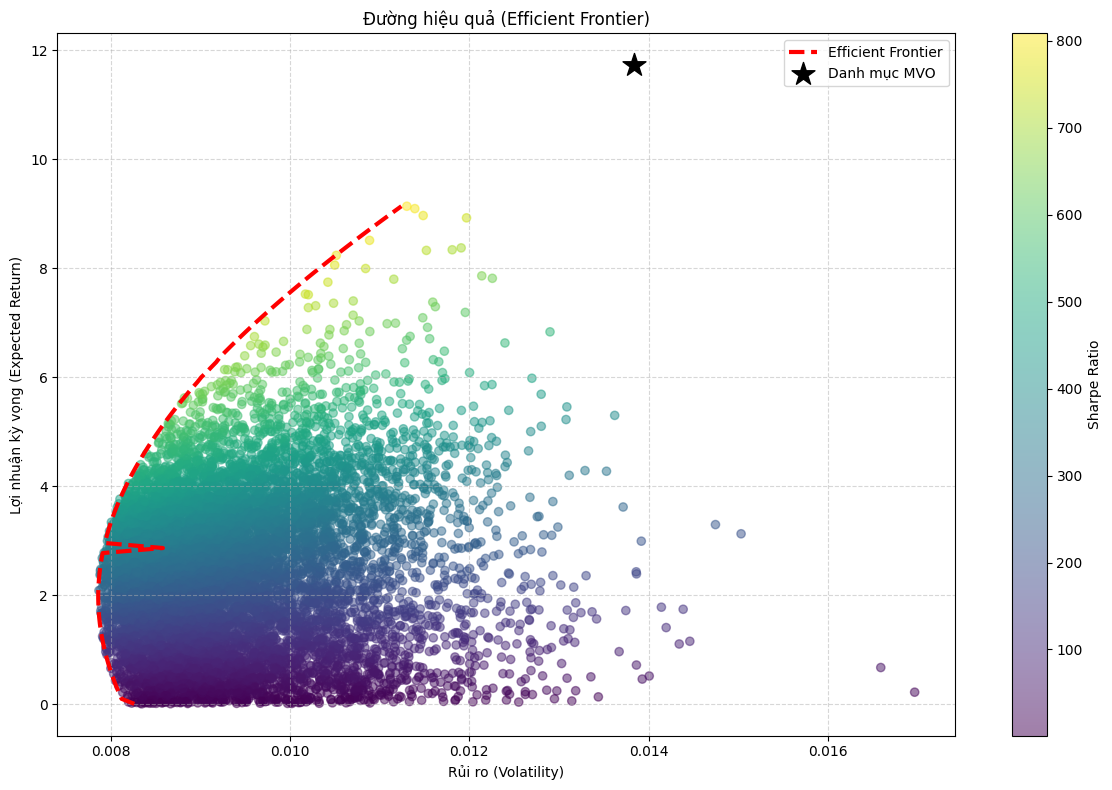

In [42]:
num_assets = len(selected_symbols)
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []
risk_free_rate = 0.02/52  # Giả sử dữ liệu tính theo tuần

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)
    
    p_ret = portfolio_return(weights, expected_returns)
    p_risk = portfolio_volatility(weights, cov_matrix)
    sharpe = (p_ret - risk_free_rate) / p_risk if p_risk > 0 else 0
    
    results[0, i] = p_ret
    results[1, i] = p_risk
    results[2, i] = sharpe

# --- Tính danh mục MVO ---
mvo_weights = mvo_optimization(expected_returns, cov_matrix, risk_free_rate=risk_free_rate, max_weight=1, alpha=0.1)
mvo_ret = portfolio_return(mvo_weights, expected_returns)
mvo_risk = portfolio_volatility(mvo_weights, cov_matrix)
mvo_sharpe = portfolio_sharpe_ratio(mvo_weights, expected_returns, cov_matrix, risk_free_rate=risk_free_rate)

# --- Tính đường biên hiệu quả ---
# Chúng ta sẽ giải bài toán "minimize volatility" với ràng buộc đạt được target return.
def min_volatility(weights, cov_matrix):
    return portfolio_volatility(weights, cov_matrix)

target_returns = np.linspace(np.min(results[0]), np.max(results[0]), 100)
efficient_risks = []

for target in target_returns:
    constraints = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # Tổng trọng số = 1
        {"type": "eq", "fun": lambda w: portfolio_return(w, expected_returns) - target}  # Lợi nhuận = target
    )
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = np.array([1/num_assets] * num_assets)
    
    opt = sco.minimize(min_volatility, init_guess, args=(cov_matrix,),
                       method="SLSQP", bounds=bounds, constraints=constraints)
    if opt.success:
        efficient_risks.append(opt.fun)
    else:
        efficient_risks.append(np.nan)

# --- Vẽ biểu đồ ---
plt.figure(figsize=(12,8))
sc = plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', alpha=0.5)
plt.plot(efficient_risks, target_returns, 'r--', linewidth=3, label='Efficient Frontier')
plt.scatter(mvo_risk, mvo_ret, marker='*', color='black', s=300, label='Danh mục MVO')
plt.colorbar(sc, label='Sharpe Ratio')
plt.title('Đường hiệu quả (Efficient Frontier)')
plt.xlabel('Rủi ro (Volatility)')
plt.ylabel('Lợi nhuận kỳ vọng (Expected Return)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## XGBoost

In [10]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.seasonal import MSTL

from feature_engine.timeseries.forecasting import LagFeatures
from feature_engine.imputation import DropMissingData
from sklearn.pipeline import Pipeline

In [11]:
def linear(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return  model.predict(X_test)

In [12]:
def xgboots(X_train, y_train, X_test):
    xgb = XGBRegressor()

    param_grid = {
        'n_estimators': [30, 40, 50, 100, 200, 300],
        'learning_rate': [0.03, 0.05, 0.1, 0.01],
        'max_depth': [3, 4, 5, 7],
        'subsample': [0.7, 0.9, 0.8],
        'colsample_bytree': [0.5, 0.7]
    }

    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters found: ", grid_search.best_params_)
    print("Best score found: ", grid_search.best_score_)
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    return y_pred


In [40]:
def feature_engine(columns):
    lag_transformer = LagFeatures(variables=[columns], periods=[1, 4, 12])
    imputer = DropMissingData()
    pipe = Pipeline(
        [
            ("lag", lag_transformer),
            ("imputer", imputer),
        ]
    )
    return pipe

def decomposing(data):
    mstl = MSTL(data.interpolate(method="linear"), periods=(4, 12))
    res = mstl.fit()
    return res

def prepare_features(data, component_name, lag_periods):
    pipe = feature_engine(component_name)
    data_transformed = pipe.fit_transform(data)
    
    feature_cols = [f"{component_name}_lag_{period}" for period in lag_periods]
    X = data_transformed[feature_cols]
    y = data_transformed[component_name]
    
    return X, y, pipe

def prepare_test_features(train_component, test_component, component_name, lag_periods, pipe):
    train_tail = train_component.iloc[-12:]
    extended_test = pd.concat([train_tail, test_component])


    test_transformed = pipe.transform(extended_test)
    

    feature_cols = [f"{component_name}_lag_{period}" for period in lag_periods]
    X_test = test_transformed[feature_cols]
    
    return X_test


In [41]:
def decompose_and_forecast(train, test, col_name, lag_periods = [1, 4, 12]):
    # Decompose tập train
    train_res = decomposing(train[col_name])
    train_components = {
        'trend': pd.DataFrame(train_res.trend),
        'seasonal_4': pd.DataFrame(train_res.seasonal["seasonal_4"]),
        'seasonal_12': pd.DataFrame(train_res.seasonal["seasonal_12"]),
        'resid': pd.DataFrame(train_res.resid)
    }

    train_tail = train.iloc[-12:]
    extended_test = pd.concat([train_tail, test])

    extended_test_res = decomposing(extended_test[col_name])

    
    test_components = {
        'trend': pd.DataFrame(extended_test_res.trend).iloc[12:],
        'seasonal_4': pd.DataFrame(extended_test_res.seasonal["seasonal_4"]).iloc[12:],
        'seasonal_12': pd.DataFrame(extended_test_res.seasonal["seasonal_12"]).iloc[12:],
        'resid': pd.DataFrame(extended_test_res.resid).iloc[12:]
    }

    component_configs = {
        'trend': {'lag_periods': lag_periods, 'model': 'linear'},
        'seasonal_4': {'lag_periods': lag_periods, 'model': 'xgboost'},
        'seasonal_12': {'lag_periods': lag_periods, 'model': 'xgboost'},
        'resid': {'lag_periods': lag_periods, 'model': 'linear'}
    }

    
    final_predictions = np.zeros(len(test))

    for component_name, config in component_configs.items():
        
        train_data = train_components[component_name]
        X_train, y_train, pipe = prepare_features(train_data, component_name, config['lag_periods'])
        
        test_data = test_components[component_name]
        X_test = prepare_test_features(train_data, test_data, component_name, config['lag_periods'], pipe)
        print(f"Component: {component_name}, X_test.shape: {X_test.shape}")
        
        scaler = StandardScaler()

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        scaler_y = MinMaxScaler(feature_range=(0, 1))
        y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        # Huấn luyện và dự báo
        if config['model'] == 'linear':
            component_predictions = linear(X_train, y_train, X_test)
        else:
            component_predictions = xgboots(X_train, y_train, X_test)
        
        # Thêm dự báo vào kết quả cuối cùng
        final_predictions += component_predictions

    return final_predictions, scaler_y


In [ ]:
def read_data_xgboost(file_path, list_stock, start_time="2010-01-01", end_time="2025-01-01"):

    data = pd.read_csv(file_path)
    results_df = {}
    for stock in list_stock:
        stock_data = data[data['stock_code'] == stock]
        
        stock_data['transaction_date'] = pd.to_datetime(stock_data['transaction_date'])
        stock_data = stock_data.groupby(pd.Grouper(key='transaction_date', freq='W')).sum().reset_index()
        
        stock_data = stock_data[(stock_data["transaction_date"] >= start_time) & (stock_data["transaction_date"] < end_time)]

        results_df[stock] = stock_data

    return results_df


In [43]:
list_stock = ['ABC', 'ABR', 'ADC', 'ADG']
all_data = read_data_xgboost("../data/processed/transaction_history.csv", list_stock=list_stock)

train = {}
test = {}
for stock in list_stock:
    stock_data = all_data[stock]

    test[stock] = stock_data[(stock_data["transaction_date"] >= "2024-01-01") & (stock_data["transaction_date"] < "2025-01-01")]
    train[stock] = stock_data[stock_data["transaction_date"] < "2024-01-01"]

In [47]:
train['ABC']

,transaction_date,stock_code,closing_price,matched_volume,matched_value,negotiated_volume,negotiated_value,opening_price,highest_price,lowest_price,change,percent
19,2017-01-01,ABCABCABCABCABC,194.8,10200.0,0.39,0.0,0.00,194.8,194.8,194.8,4.8,12.97
20,2017-01-08,ABCABCABCABC,167.2,0.0,0.00,0.0,0.00,167.2,167.2,167.2,0.0,0.00
21,2017-01-15,ABCABCABCABCABC,194.9,3900.0,0.14,0.0,0.00,194.9,194.9,194.9,-4.7,-11.24
22,2017-01-22,ABCABCABCABCABC,185.5,0.0,0.00,0.0,0.00,185.5,185.5,185.5,0.0,0.00
23,2017-01-29,ABCABCABC,111.3,0.0,0.00,0.0,0.00,111.3,111.3,111.3,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
380,2023-12-03,ABCABCABCABCABC,69.5,10173.0,0.13,0.0,0.00,68.9,69.6,66.9,0.7,5.17
381,2023-12-10,ABCABCABCABCABC,69.4,73889.0,0.96,0.0,0.00,68.1,69.8,65.4,1.8,14.52
382,2023-12-17,ABCABCABCABCABC,68.2,35928.0,0.47,0.0,0.00,68.1,68.8,64.5,1.8,13.60
383,2023-12-24,ABCABCABCABCABC,66.5,18152.0,0.23,1000000.0,11.40,66.0,66.7,64.8,0.8,6.10


In [ ]:
all_predictions = {}
all_models = {}
all_stats = {}

market_returns_data = pd.DataFrame()

for stock_code in list_stock:
    
    stock_data_train = train[stock_code]
    stock_data_test = test[stock_code]

    market_returns_data[stock_code] = stock_data_train['closing_price'].pct_change()[-52:].reset_index(drop=True)

    xgb_pred, scaler_y = decompose_and_forecast(stock_data_train, stock_data_test, col_name="closing_price")
    all_predictions[stock_code] = {'y_test': stock_data_test['closing_price'].values, 'y_pred': scaler_y.inverse_transform(xgb_pred.reshape(-1, 1)).flatten()}

    risk_stats = calculate_returns_risk(xgb_pred, scaler_y)

    all_stats[stock_code] = {
        'stats': risk_stats
    }


Component: trend, X_test.shape: (52, 3)
Component: seasonal_4, X_test.shape: (52, 3)
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=50,

In [45]:
expected_returns = []
risks = []
sharpe_ratios = []
market_caps = [] 

stocks_by_sharpe = sorted(
    all_stats.items(), 
    key=lambda x: x[1]['stats']['sharpe_ratio'], 
    reverse=True
)

top_n = min(len(stocks_by_sharpe), 4)  # Chọn top 4 cổ phiếu
selected_stocks = stocks_by_sharpe[:top_n]

selected_symbols = []
for symbol, stats in selected_stocks:
    selected_symbols.append(symbol)
    expected_returns.append(stats['stats']['expected_return'])
    risks.append(stats['stats']['risk'])
    sharpe_ratios.append(stats['stats']['sharpe_ratio'])

market_data = market_returns_data[selected_symbols].values
market_data = np.nan_to_num(market_data, nan=0.0, posinf=0.0, neginf=0.0)
cov_matrix = np.cov(market_data, rowvar=False)

views = expected_returns.copy()
for i in range(len(views)):
    # Điều chỉnh quan điểm dựa trên một số phân tích giả định
    if sharpe_ratios[i] > 1.0:  # Cổ phiếu có Sharpe cao được đánh giá tích cực hơn
        views[i] *= 1.1  # Tăng lợi nhuận kỳ vọng thêm 10%
    elif sharpe_ratios[i] < 0.5:  # Cổ phiếu có Sharpe thấp được đánh giá tiêu cực hơn
        views[i] *= 0.9  # Giảm lợi nhuận kỳ vọng đi 10%

mvo_weights = mvo_optimization(expected_returns, cov_matrix, max_weight=1)

    # mc_results = monte_carlo_simulation(expected_returns, cov_matrix)
    # mc_weights = mc_results['max_sharpe']['weights']
    # min_vol_weights = mc_results['min_volatility']['weights']


print("MVO")
port_return = portfolio_return(mvo_weights, expected_returns)
port_risk = portfolio_volatility(mvo_weights, cov_matrix)
port_sharpe = (port_return - 0.02/52) / port_risk if port_risk > 0 else 0

print(f"  Expected Return: {port_return:.6f}")
print(f"  Risk: {port_risk:.6f}")
print(f"  Sharpe Ratio: {port_sharpe:.6f}")
print("  Weights:")
for i, symbol in enumerate(selected_symbols):
        print(f"    {symbol}: {mvo_weights[i]:.4f} ({mvo_weights[i]*100:.2f}%)")

optimization_results = {}
optimization_results["mvo"] = {
        'weights': mvo_weights,
        'return': port_return,
        'risk': port_risk,
        'sharpe': port_sharpe
    }

MVO
  Expected Return: 0.017141
  Risk: 0.368013
  Sharpe Ratio: 0.045533
  Weights:
    ADC: 0.4672 (46.72%)
    ABR: 0.2400 (24.00%)
    ABC: 0.1325 (13.25%)
    ADG: 0.1604 (16.04%)


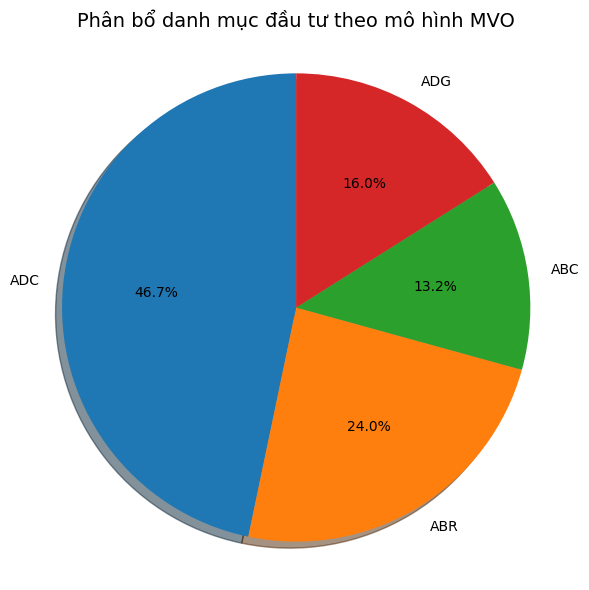

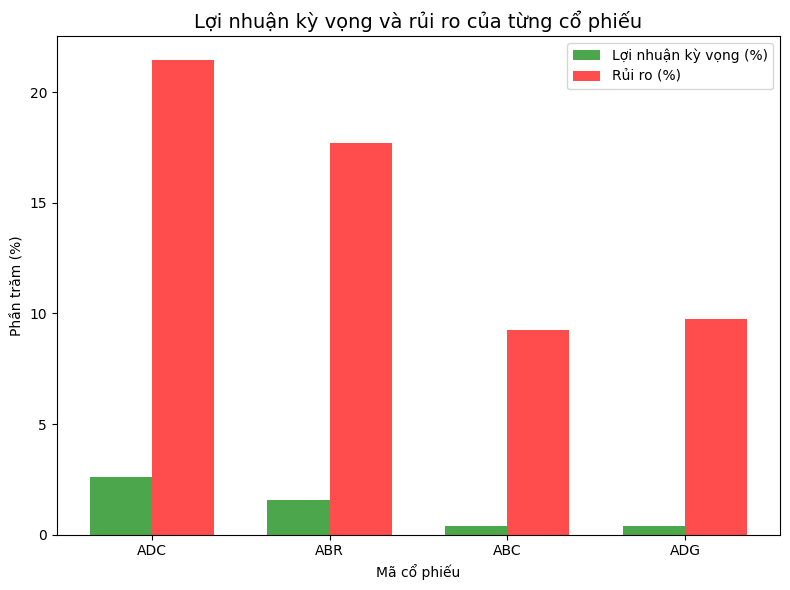

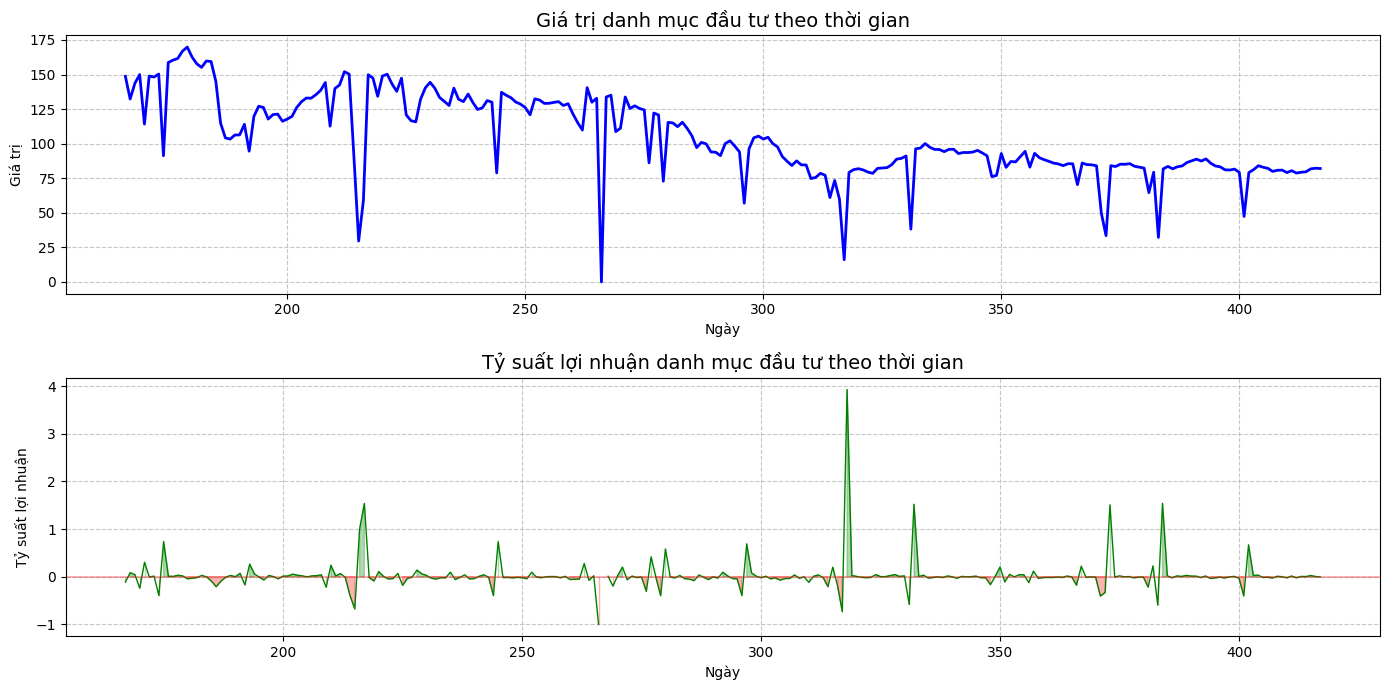

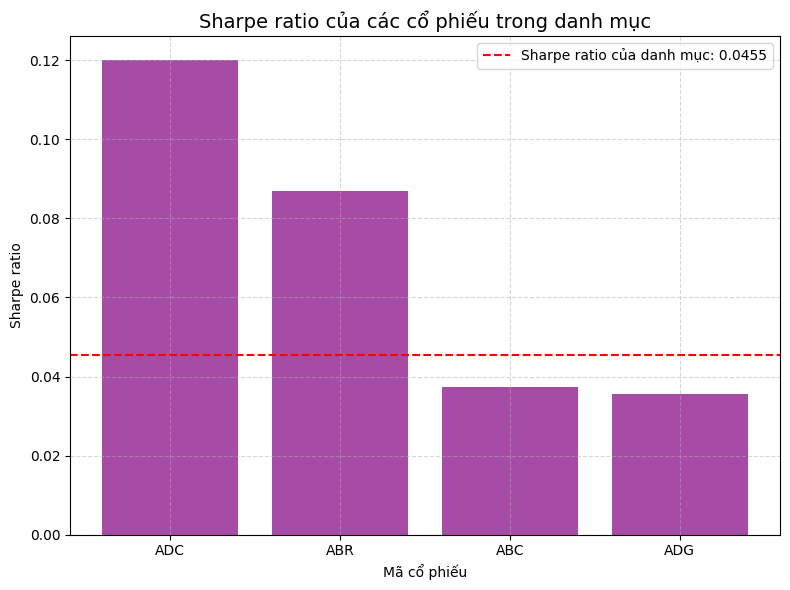

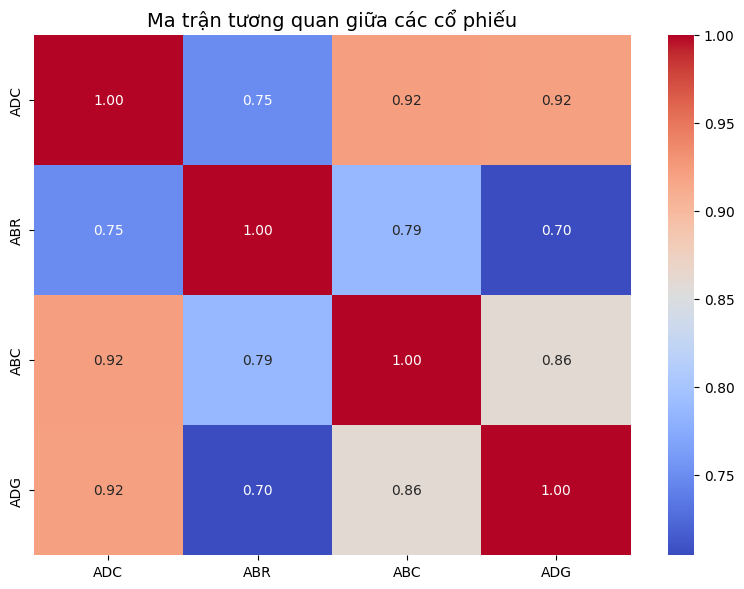

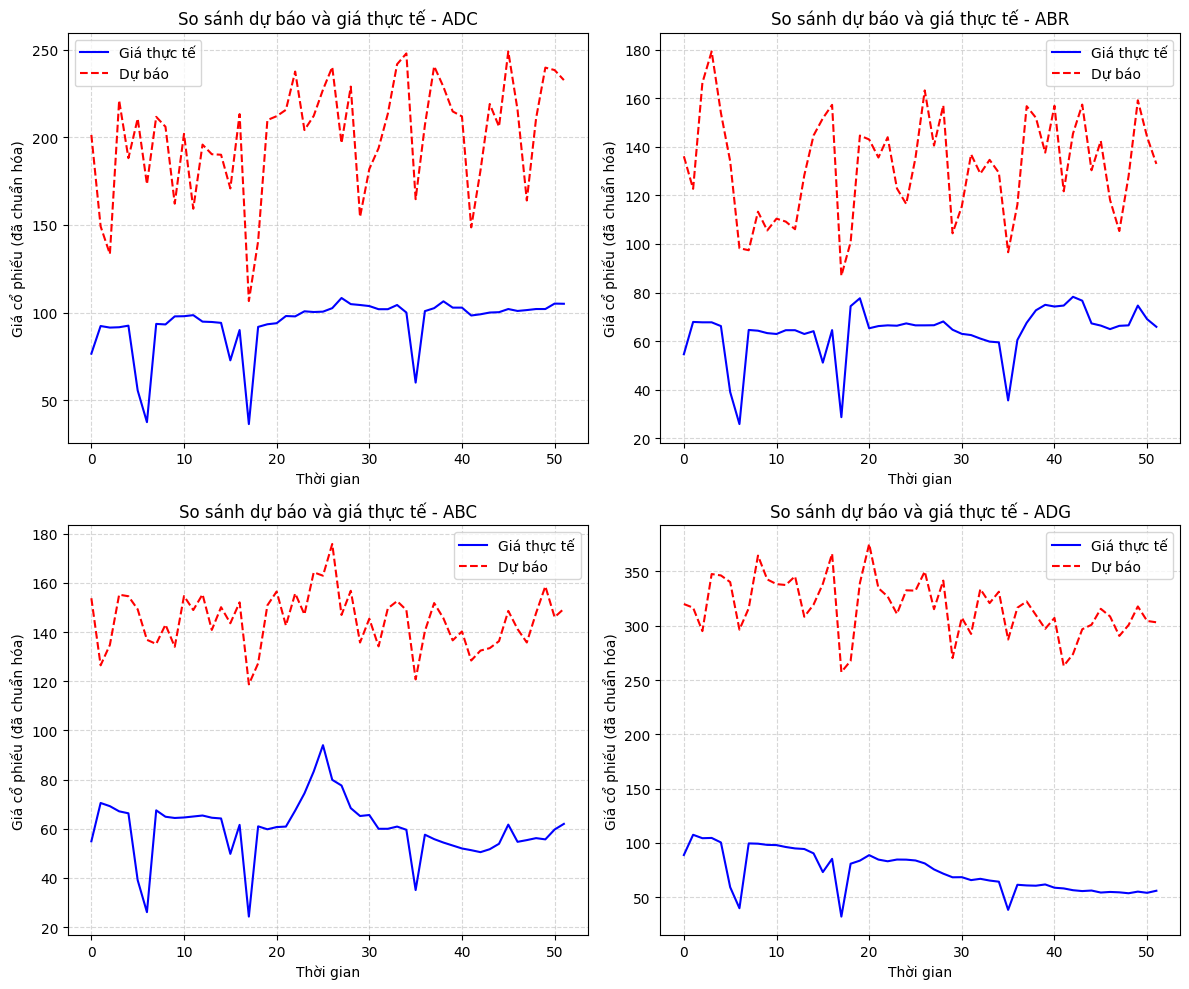

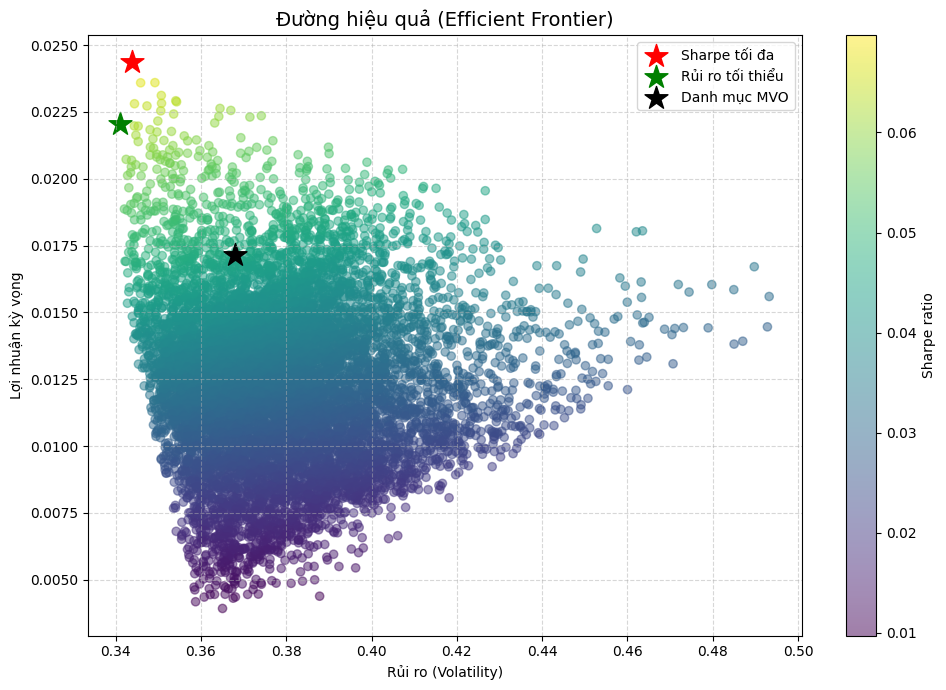


Bảng thống kê tổng hợp danh mục đầu tư:
Cổ phiếu  Trọng số (%)  Lợi nhuận kỳ vọng (%)  Rủi ro (%)  Sharpe ratio
     ADC         46.72                   2.62       21.47          0.12
     ABR         24.00                   1.58       17.71          0.09
     ADG         16.04                   0.38        9.73          0.04
     ABC         13.25                   0.38        9.26          0.04

Kết quả tổng hợp:
Cổ phiếu  Trọng số (%)  Lợi nhuận kỳ vọng (%)  Rủi ro (%)  Sharpe ratio
     ADC         46.72                   2.62       21.47          0.12
     ABR         24.00                   1.58       17.71          0.09
     ADG         16.04                   0.38        9.73          0.04
     ABC         13.25                   0.38        9.26          0.04
    TỔNG        100.00                   1.71       36.80          0.05


In [46]:
from plot_results import *

plot_portfolio_allocation(mvo_weights, selected_symbols)
plot_return_risk_comparison(expected_returns, risks, selected_symbols)
plot_portfolio_performance(all_data, selected_symbols, mvo_weights)
plot_sharpe_ratios(selected_symbols, sharpe_ratios, port_sharpe)
plot_correlation_matrix(market_data, selected_symbols)
plot_prediction_comparison(all_predictions, selected_symbols)
plot_efficient_frontier(selected_symbols, expected_returns, cov_matrix, port_risk, port_return)
print_summary_table(selected_symbols, mvo_weights, expected_returns, risks, sharpe_ratios, 
                    port_return, port_risk, port_sharpe)